# Principle Component Analysis for Crowed at Gym Prediction
# by- Uddesh Soman


Goals

Given a time of day (and maybe some other features, including weather), predict how crowded the gym will be.
Figure out which features are actually important, which are redundant, and what features could be added to make the predictions more accurate.

Data

The dataset consists of 26,000 people counts (about every 10 minutes) over the last year. In addition, I gathered extra info including weather and semester-specific information that might affect how crowded it is. The label is the number of people, which I'd like to predict given some subset of the features.

Label:

Number of people

Features:

date (string; datetime of data)

timestamp (int; number of seconds since beginning of day)

dayofweek (int; 0 [monday] - 6 [sunday])

is_weekend (int; 0 or 1) [boolean, if 1, it's either saturday or sunday, otherwise 0]

is_holiday (int; 0 or 1) [boolean, if 1 it's a federal holiday, 0 otherwise]

temperature (float; degrees fahrenheit)

isstartof_semester (int; 0 or 1) [boolean, if 1 it's the beginning of a school semester, 0 otherwise]

month (int; 1 [jan] - 12 [dec])

hour (int; 0 - 23)

Here the problem is of regression type so we are going to use linear regression as our basline model, followed by decision tree regressor, randomforest regressor and Xgboost regressor. We will train and test on all of them, once with original data and after Box Cox transformation. Here I will carry out PCA on Box Cox Transformed data as it has better accuracy and compare all the results. 

In [1]:
# importing required libraries for data analysis
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
#inline plots
%matplotlib inline

In [2]:
# supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
gym = pd.read_csv('gym_data.csv')

In [4]:
# getting a look at the data
gym.head()

number_people                       date  timestamp  day_of_week  \
0             37  2015-08-14 17:00:11-07:00      61211            4   
1             45  2015-08-14 17:20:14-07:00      62414            4   
2             40  2015-08-14 17:30:15-07:00      63015            4   
3             44  2015-08-14 17:40:16-07:00      63616            4   
4             45  2015-08-14 17:50:17-07:00      64217            4   

   is_weekend  is_holiday  temperature  is_start_of_semester  \
0           0           0        71.76                     0   
1           0           0        71.76                     0   
2           0           0        71.76                     0   
3           0           0        71.76                     0   
4           0           0        71.76                     0   

   is_during_semester  month  hour  
0                   0      8    17  
1                   0      8    17  
2                   0      8    17  
3                   0      8    17  
4                   0      8    17

In [5]:
gym.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [6]:
# getting statistical overview of the data
gym.describe().transpose()

count          mean           std    min      25%  \
number_people         62184.0     29.072543     22.689026   0.00      9.0   
timestamp             62184.0  45799.437958  24211.275891   0.00  26624.0   
day_of_week           62184.0      2.982504      1.996825   0.00      1.0   
is_weekend            62184.0      0.282870      0.450398   0.00      0.0   
is_holiday            62184.0      0.002573      0.050660   0.00      0.0   
temperature           62184.0     58.557108      6.316396  38.14     55.0   
is_start_of_semester  62184.0      0.078831      0.269476   0.00      0.0   
is_during_semester    62184.0      0.660218      0.473639   0.00      0.0   
month                 62184.0      7.439824      3.445069   1.00      5.0   
hour                  62184.0     12.236460      6.717631   0.00      7.0   

                           50%       75%       max  
number_people            28.00     43.00    145.00  
timestamp             46522.50  66612.00  86399.00  
day_of_week               3.00      5.00      6.00  
is_weekend                0.00      1.00      1.00  
is_holiday                0.00      0.00      1.00  
temperature              58.34     62.28     87.17  
is_start_of_semester      0.00      0.00      1.00  
is_during_semester        1.00      1.00      1.00  
month                     8.00     10.00     12.00  
hour                     12.00     18.00     23.00

In [7]:
# getting null values
def nullvalues(data):
    ls = [] 
    for i in data.columns:
        if data[i].isnull().sum() > 0:
            ls.append([i, data[i].isnull().sum()])
    if len(ls) != 0:
        print('Null values are present in ', ls)
        for i in ls:  # getting Percentage Null values and their datatype
            nullpercent = i[1]/data.shape[0]
            nullpercent = round(nullpercent,6)
            dt = type(data[i[0]][1])
            print(f'Null percentage in {i[0]} is {nullpercent * 100} % and datatype {dt}')
            return ls
    else: print('No Null values')

In [8]:
nullvalues(gym)

No Null values


The data is clean with no nulls or improper fillers. Here I will extract date of month and minutes of hour from the date feature as these seem relevant features. I would have also considered humidity and season but those features are not available in the data, neither can be constructed using available variables.  Seasons could be derived using months but I'm not sure about the location of gym so can't assign it ambigiously.

In [9]:
type(gym.date[0])

str

In [10]:
# the object is of type str so we 
# extracting date and minutes using pandas.to_datetime
#we can use string split with lambda and apply but using pandas datetime object is easier
gym['date'] = pd.to_datetime(gym['date'])

In [11]:
gym['minute'] = gym['date'].apply(lambda x: x.minute)
gym['day'] = gym['date'].apply(lambda x: x.day)
gym.head().transpose()

0                          1  \
number_people                                37                         45   
date                  2015-08-14 17:00:11-07:00  2015-08-14 17:20:14-07:00   
timestamp                                 61211                      62414   
day_of_week                                   4                          4   
is_weekend                                    0                          0   
is_holiday                                    0                          0   
temperature                               71.76                      71.76   
is_start_of_semester                          0                          0   
is_during_semester                            0                          0   
month                                         8                          8   
hour                                         17                         17   
minute                                        0                         20   
day                                          14                         14   

                                              2                          3  \
number_people                                40                         44   
date                  2015-08-14 17:30:15-07:00  2015-08-14 17:40:16-07:00   
timestamp                                 63015                      63616   
day_of_week                                   4                          4   
is_weekend                                    0                          0   
is_holiday                                    0                          0   
temperature                               71.76                      71.76   
is_start_of_semester                          0                          0   
is_during_semester                            0                          0   
month                                         8                          8   
hour                                         17                         17   
minute                                       30                         40   
day                                          14                         14   

                                              4  
number_people                                45  
date                  2015-08-14 17:50:17-07:00  
timestamp                                 64217  
day_of_week                                   4  
is_weekend                                    0  
is_holiday                                    0  
temperature                               71.76  
is_start_of_semester                          0  
is_during_semester                            0  
month                                         8  
hour                                         17  
minute                                       50  
day                                          14

In [12]:
# we can drop date column as it is no longer required
gym.drop('date', axis = 1, inplace = True)
gym.head()

number_people  timestamp  day_of_week  is_weekend  is_holiday  temperature  \
0             37      61211            4           0           0        71.76   
1             45      62414            4           0           0        71.76   
2             40      63015            4           0           0        71.76   
3             44      63616            4           0           0        71.76   
4             45      64217            4           0           0        71.76   

   is_start_of_semester  is_during_semester  month  hour  minute  day  
0                     0                   0      8    17       0   14  
1                     0                   0      8    17      20   14  
2                     0                   0      8    17      30   14  
3                     0                   0      8    17      40   14  
4                     0                   0      8    17      50   14

In [13]:
#checking null again
nullvalues(gym)

No Null values


In [14]:
# checking uniques
for i in gym.columns:
    print(i, gym[i].nunique())

number_people 128
timestamp 31321
day_of_week 7
is_weekend 2
is_holiday 2
temperature 2599
is_start_of_semester 2
is_during_semester 2
month 12
hour 24
minute 60
day 31


In [15]:
# checking info for datatypes
gym.info() # all should be numerical, int or float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   timestamp             62184 non-null  int64  
 2   day_of_week           62184 non-null  int64  
 3   is_weekend            62184 non-null  int64  
 4   is_holiday            62184 non-null  int64  
 5   temperature           62184 non-null  float64
 6   is_start_of_semester  62184 non-null  int64  
 7   is_during_semester    62184 non-null  int64  
 8   month                 62184 non-null  int64  
 9   hour                  62184 non-null  int64  
 10  minute                62184 non-null  int64  
 11  day                   62184 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 5.7 MB


# exploratory data analysis using seaborn and matplotlib

In [16]:
gym.head()

number_people  timestamp  day_of_week  is_weekend  is_holiday  temperature  \
0             37      61211            4           0           0        71.76   
1             45      62414            4           0           0        71.76   
2             40      63015            4           0           0        71.76   
3             44      63616            4           0           0        71.76   
4             45      64217            4           0           0        71.76   

   is_start_of_semester  is_during_semester  month  hour  minute  day  
0                     0                   0      8    17       0   14  
1                     0                   0      8    17      20   14  
2                     0                   0      8    17      30   14  
3                     0                   0      8    17      40   14  
4                     0                   0      8    17      50   14

<AxesSubplot:>

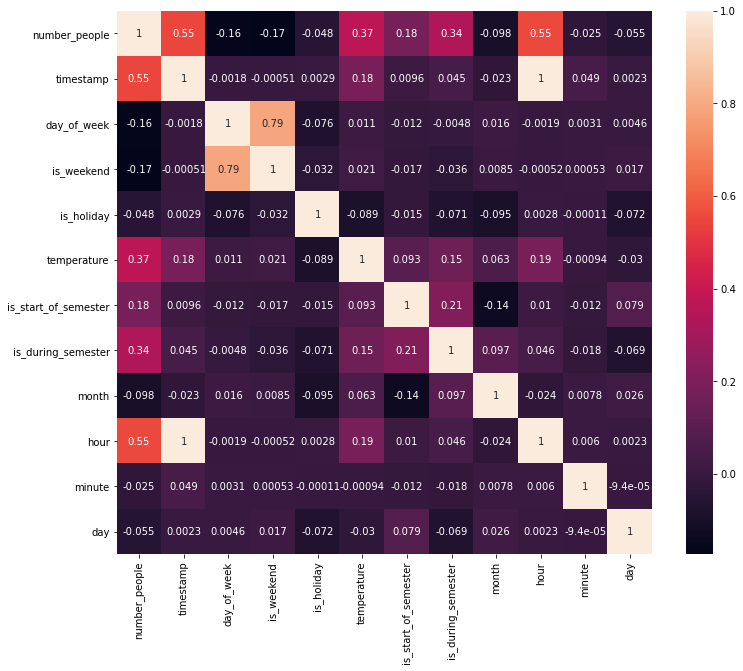

In [17]:
#getting correlation matrix
mat = gym.corr()
fig = plt.figure(figsize =(12,10))
sns.heatmap(mat, annot = True)

Most of the features are independent of each other, except for timestamp and hour which are perfectly linear to each othe hence have correlation 1. We will drop them based on information gain they provide to our model. Weekend has strong correlation with day of weak. we will keep both in baseline model and proceed according to PCA.

On the downside neither of the feature show any strong coorelation with our target variable so prediction may become hard. We will see the normality of the data and see if Box Cox transformation could help us getting better relations with target data.

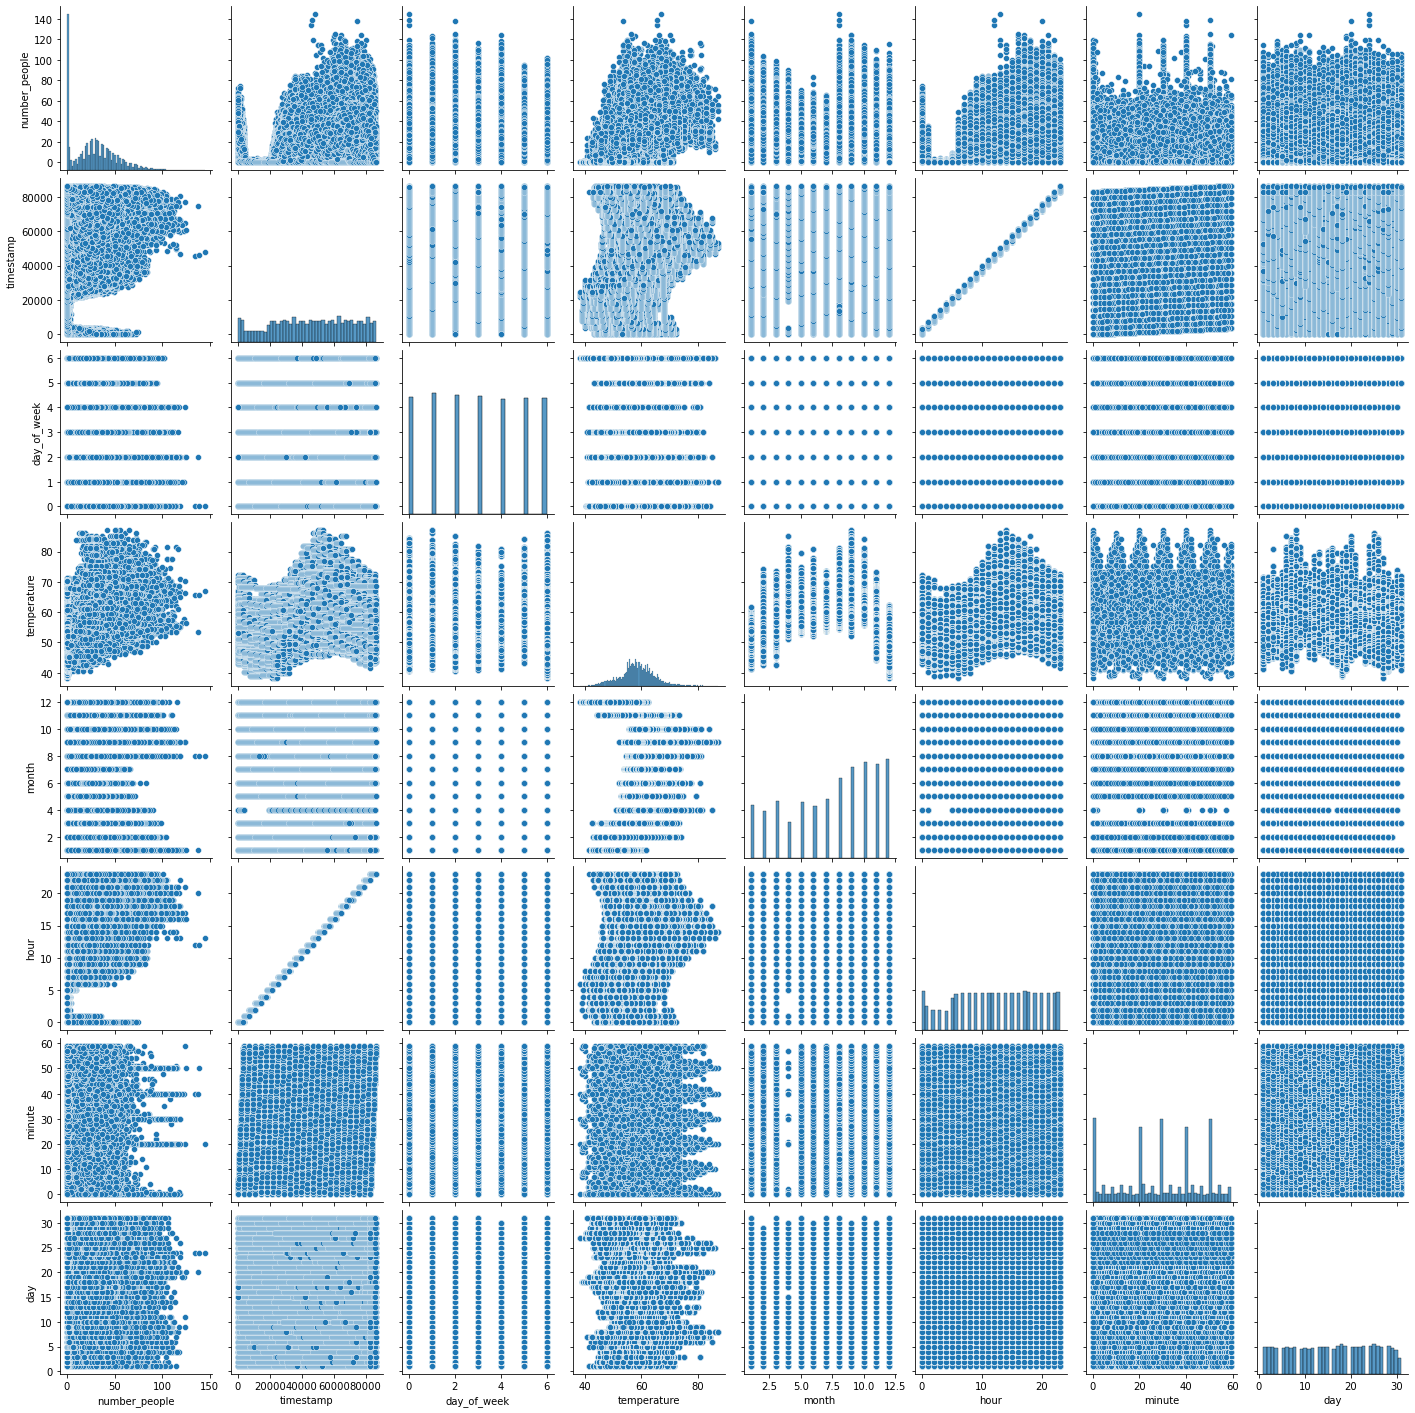

In [18]:
# Getting pairplots among numerical columns to see their relationships
cols = ['number_people', 'timestamp', 'day_of_week', 'temperature', 'month', 'hour', 'minute', 'day']
sns.pairplot(gym[cols])

<AxesSubplot:title={'center':'Histplot for number of people'}, xlabel='number_people', ylabel='Count'>

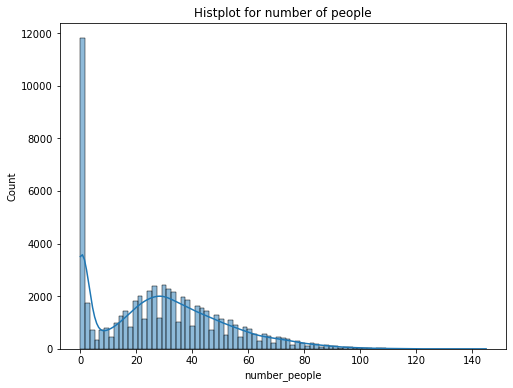

In [19]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for number of people')
sns.histplot(gym.number_people, kde = True)

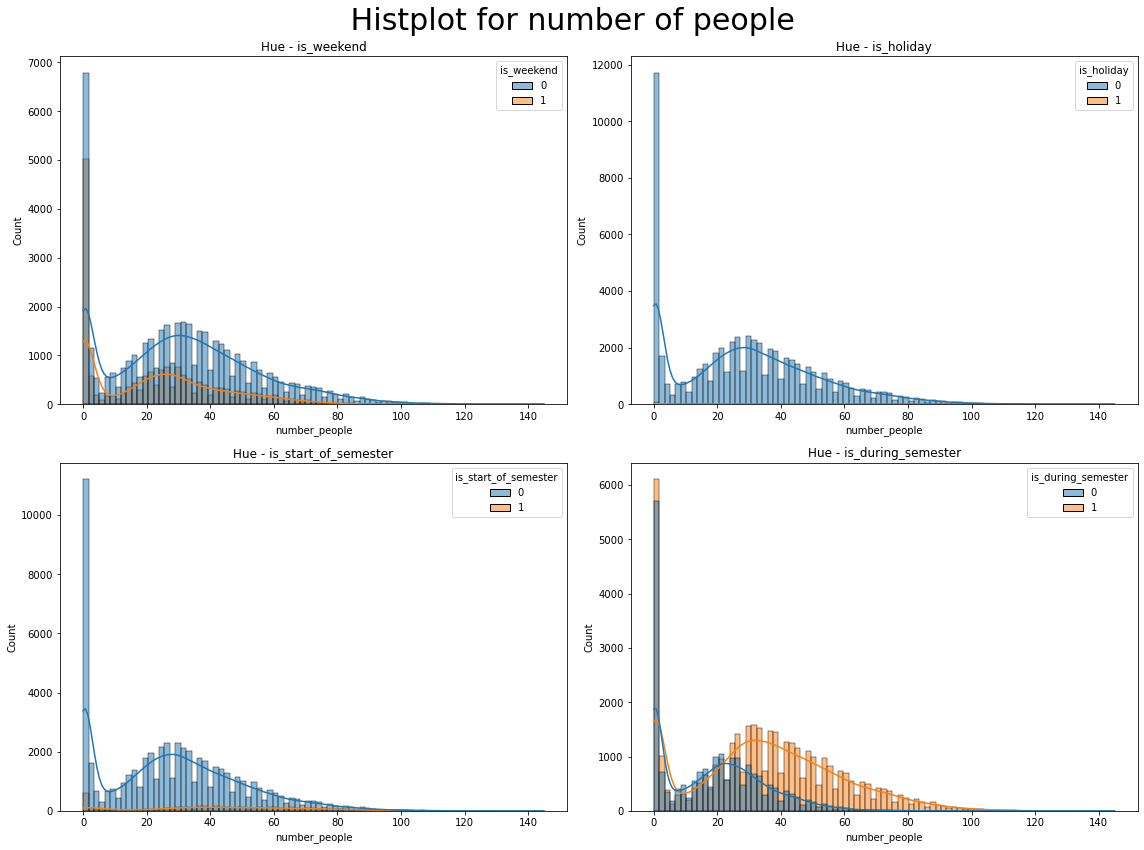

In [20]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Histplot for number of people ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.histplot(x = 'number_people',data = gym, hue = 'is_weekend', kde = True, ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.histplot(x = 'number_people',data = gym, hue = 'is_holiday', kde = True, ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.histplot(x = 'number_people',data = gym, hue = 'is_start_of_semester', kde = True, ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.histplot(x = 'number_people',data = gym, hue = 'is_during_semester', kde = True, ax = ax[1][1])
plt.tight_layout()

Number of people data is not normally distributed. The lower end is extremly peaked and some skewness to the right. The croud appears more on weekdays, non holidays. More counts for any number of people is some time after the beginning of semester. Croud is more likely during semesters and not breaks.

<AxesSubplot:title={'center':'Histplot for Timestamp'}, xlabel='timestamp', ylabel='Count'>

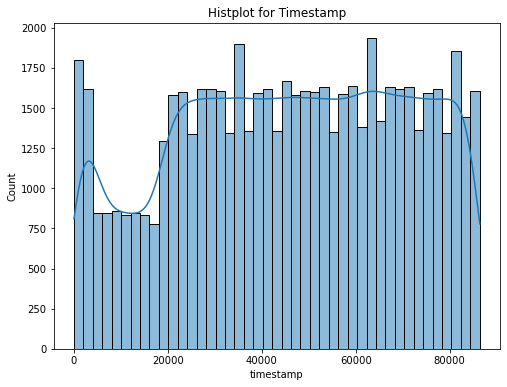

In [21]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for Timestamp')
sns.histplot(gym.timestamp, kde = True)

The count of various timestamps is not normally distributed

<AxesSubplot:title={'center':'Histplot for Temperature'}, xlabel='temperature', ylabel='Count'>

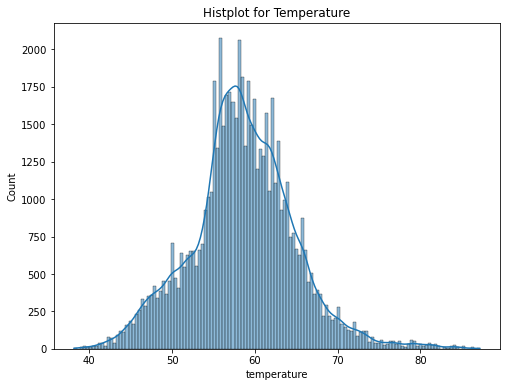

In [22]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for Temperature')
sns.histplot(gym.temperature, kde = True)

Temperature has somewhat normal distribution which is good.


<AxesSubplot:title={'center':'Histplot for day'}, xlabel='day', ylabel='Count'>

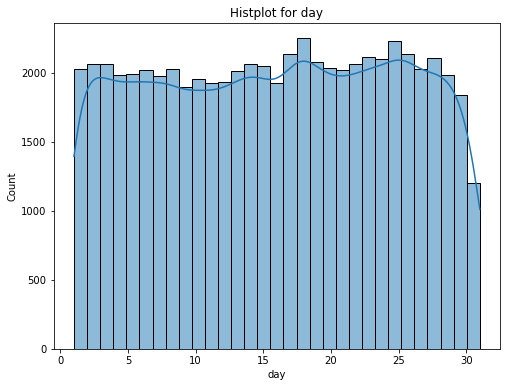

In [23]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for day')
sns.histplot(gym.day, kde = True, bins = 31)

The data is not normally distributed

<AxesSubplot:title={'center':'Histplot for day_of_week'}, xlabel='day_of_week', ylabel='Count'>

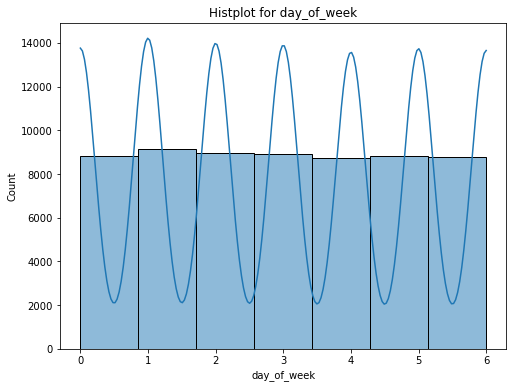

In [24]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for day_of_week')
sns.histplot(gym.day_of_week, kde = True, bins = 7)

The data is not normally distributed

<AxesSubplot:title={'center':'Histplot for month'}, xlabel='month', ylabel='Count'>

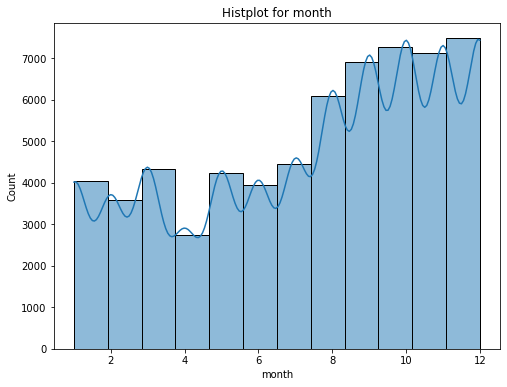

In [25]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for month')
sns.histplot(gym.month, kde = True, bins = 12)

The data is not normally distributed

<AxesSubplot:title={'center':'Histplot for hour'}, xlabel='hour', ylabel='Count'>

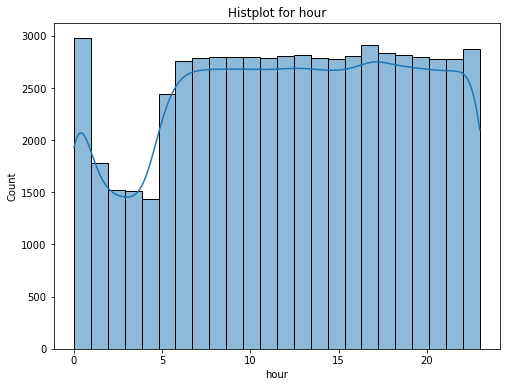

In [26]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for hour')
sns.histplot(gym.hour, kde = True,bins = 24 )

The data is not normally distributed

<AxesSubplot:title={'center':'Histplot for minute'}, xlabel='minute', ylabel='Count'>

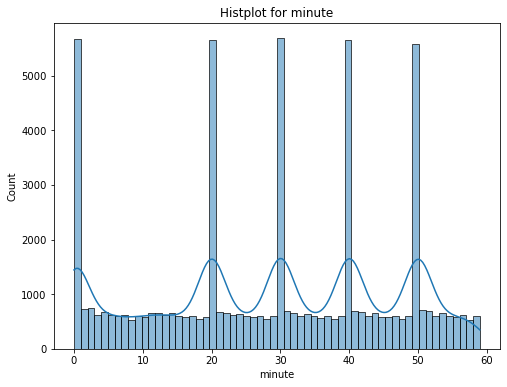

In [27]:
fig = plt.figure(figsize = (8,6))
plt.title('Histplot for minute')
sns.histplot(gym.minute, kde = True, bins = 60 )

The data is not normally distributed

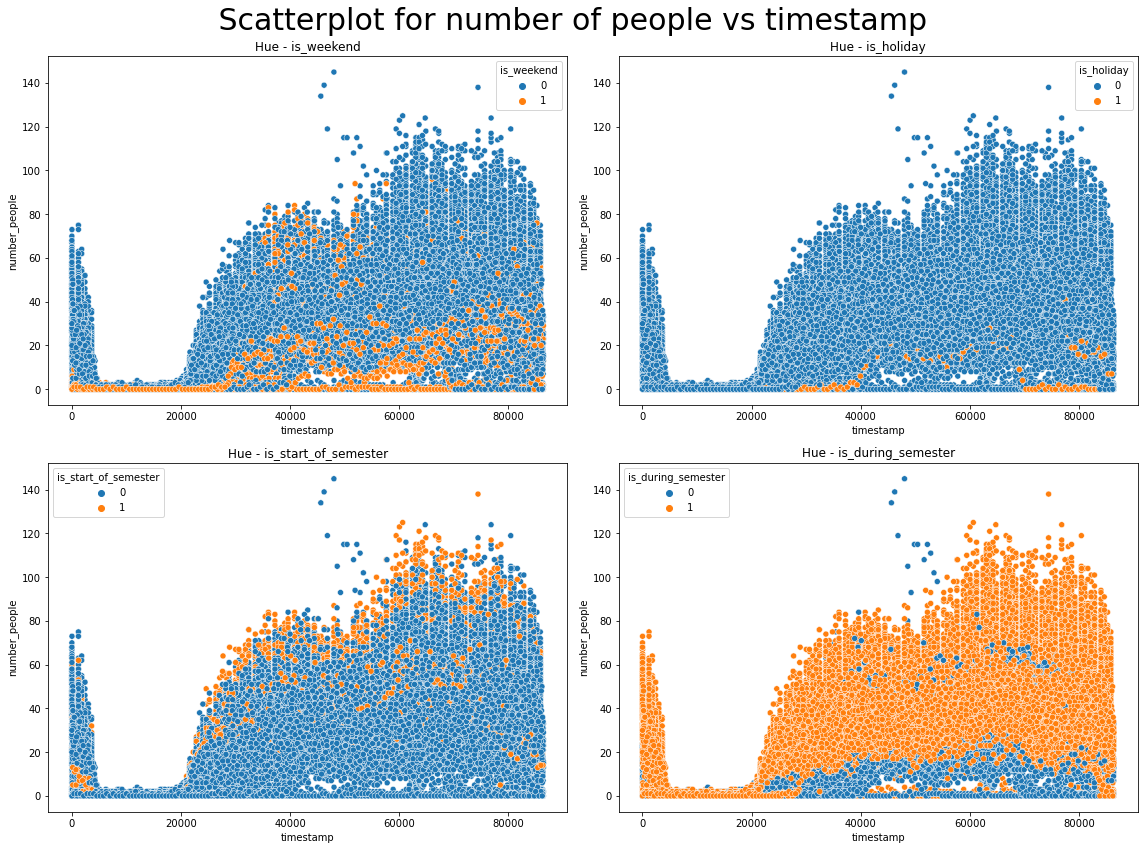

In [28]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Scatterplot for number of people vs timestamp ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.scatterplot(x='timestamp' ,y = 'number_people',data = gym, hue = 'is_weekend', ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.scatterplot(x = 'timestamp',y = 'number_people',data = gym, hue = 'is_holiday',  ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.scatterplot(x = 'timestamp',y = 'number_people',data = gym, hue = 'is_start_of_semester',  ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.scatterplot(x = 'timestamp',y = 'number_people',data = gym, hue = 'is_during_semester', ax = ax[1][1])
plt.tight_layout()

The data is not linear in nature with respect to the target variable.

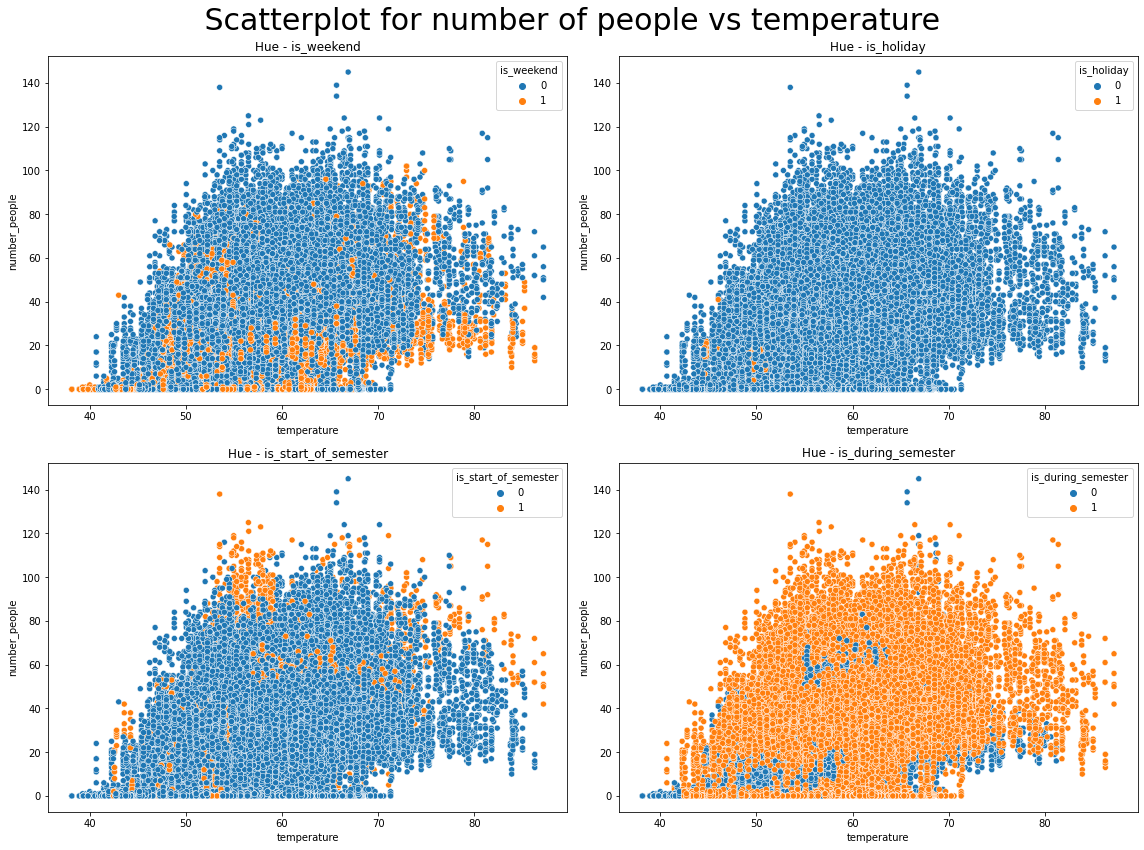

In [29]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Scatterplot for number of people vs temperature ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.scatterplot(x='temperature' ,y = 'number_people',data = gym, hue = 'is_weekend', ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.scatterplot(x = 'temperature',y = 'number_people',data = gym, hue = 'is_holiday',  ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.scatterplot(x = 'temperature',y = 'number_people',data = gym, hue = 'is_start_of_semester',  ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.scatterplot(x = 'temperature',y = 'number_people',data = gym, hue = 'is_during_semester', ax = ax[1][1])
plt.tight_layout()

The data isnt linear and peaks in 50 'F to 70 'f range

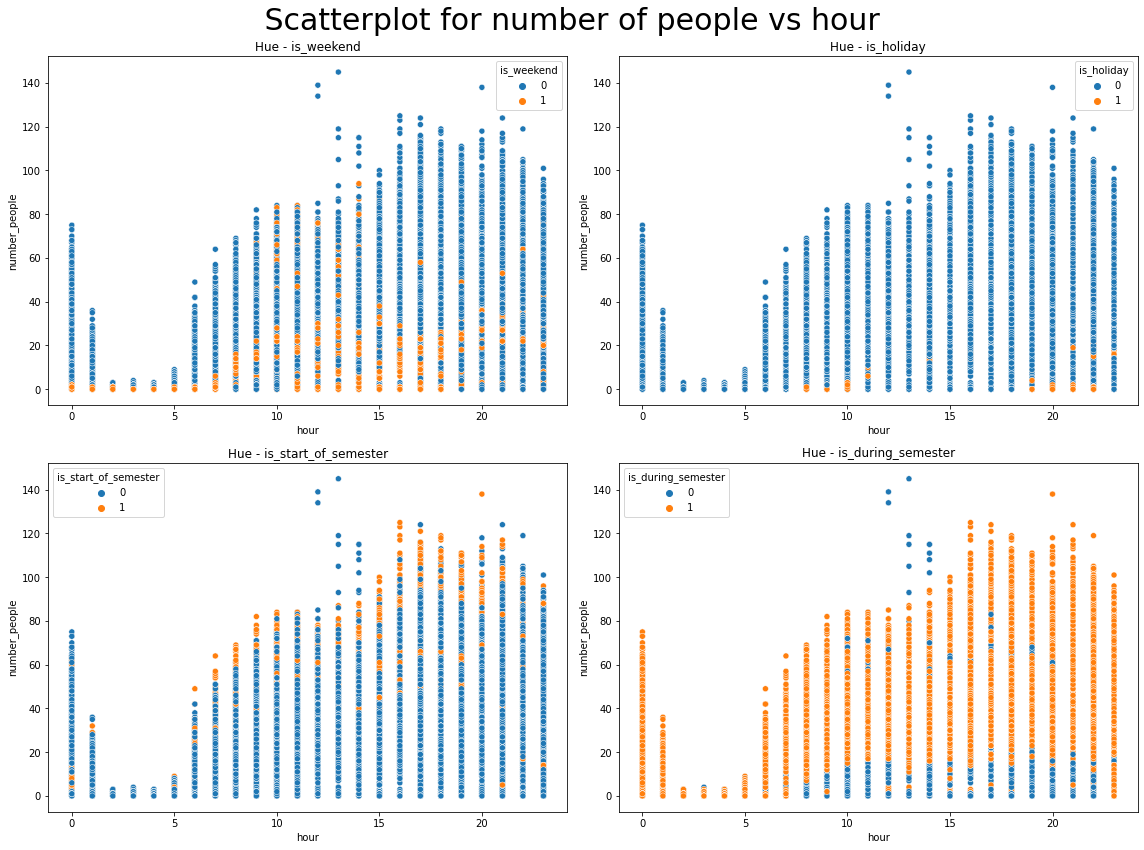

In [30]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Scatterplot for number of people vs hour ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.scatterplot(x='hour' ,y = 'number_people',data = gym, hue = 'is_weekend', ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.scatterplot(x = 'hour',y = 'number_people',data = gym, hue = 'is_holiday',  ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.scatterplot(x = 'hour',y = 'number_people',data = gym, hue = 'is_start_of_semester',  ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.scatterplot(x = 'hour',y = 'number_people',data = gym, hue = 'is_during_semester', ax = ax[1][1])
plt.tight_layout()

The data is not linear in nature with respect to the target variable.

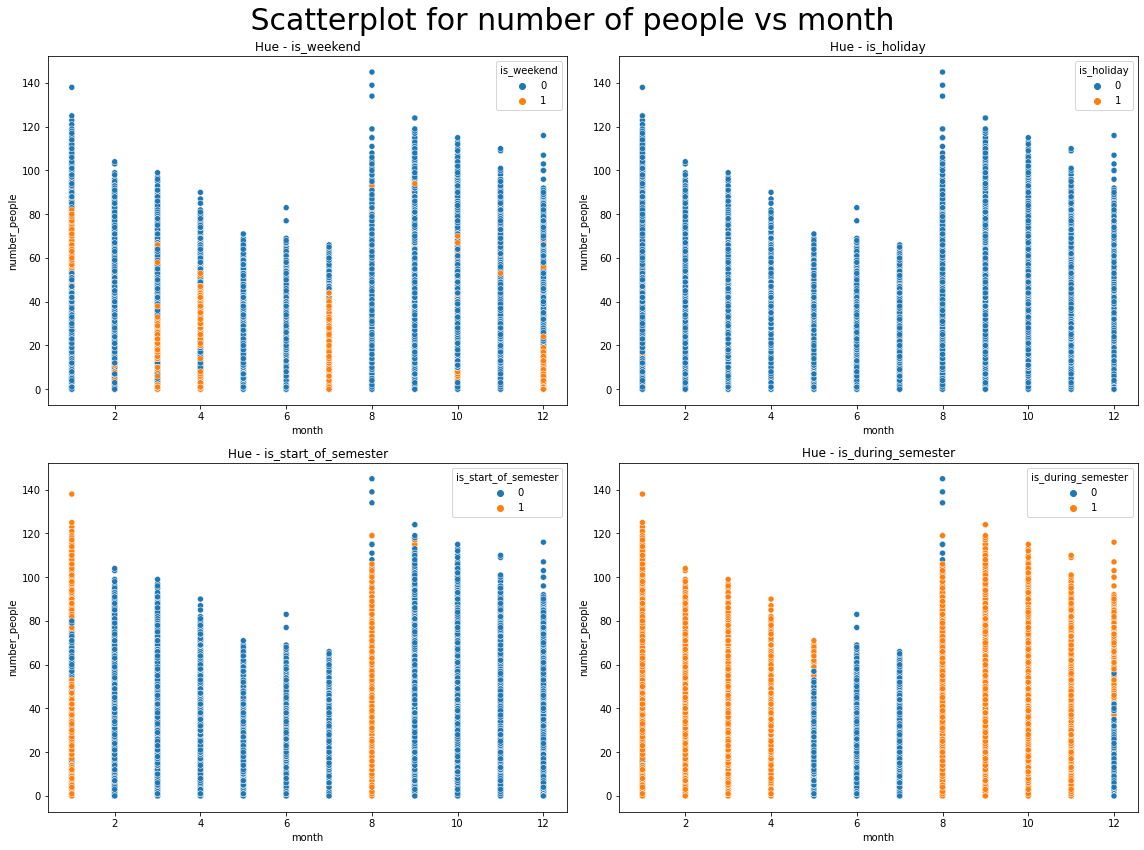

In [31]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Scatterplot for number of people vs month ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.scatterplot(x='month' ,y = 'number_people',data = gym, hue = 'is_weekend', ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.scatterplot(x = 'month',y = 'number_people',data = gym, hue = 'is_holiday',  ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.scatterplot(x = 'month',y = 'number_people',data = gym, hue = 'is_start_of_semester',  ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.scatterplot(x = 'month',y = 'number_people',data = gym, hue = 'is_during_semester', ax = ax[1][1])
plt.tight_layout()

The data is not linear in nature with respect to the target variable.

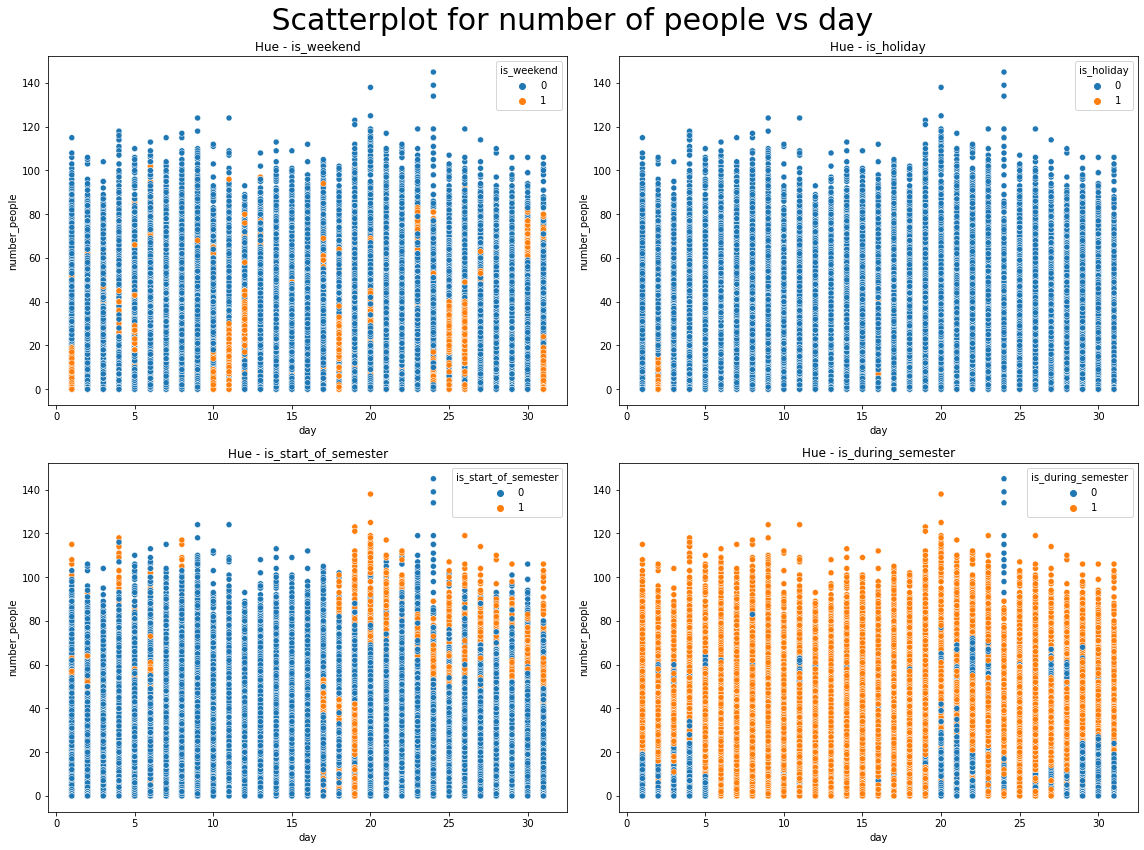

In [32]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
fig.suptitle(' Scatterplot for number of people vs day ', fontsize=30)
ax[0][0].set_title('Hue - is_weekend')
sns.scatterplot(x='day' ,y = 'number_people',data = gym, hue = 'is_weekend', ax = ax[0][0])
ax[0][1].set_title('Hue - is_holiday')
sns.scatterplot(x = 'day',y = 'number_people',data = gym, hue = 'is_holiday',  ax = ax[0][1])
ax[1][0].set_title('Hue - is_start_of_semester')
sns.scatterplot(x = 'day',y = 'number_people',data = gym, hue = 'is_start_of_semester',  ax = ax[1][0])
ax[1][1].set_title('Hue - is_during_semester')
sns.scatterplot(x = 'day',y = 'number_people',data = gym, hue = 'is_during_semester', ax = ax[1][1])
plt.tight_layout()

The data is not linear in nature with respect to the target variable.

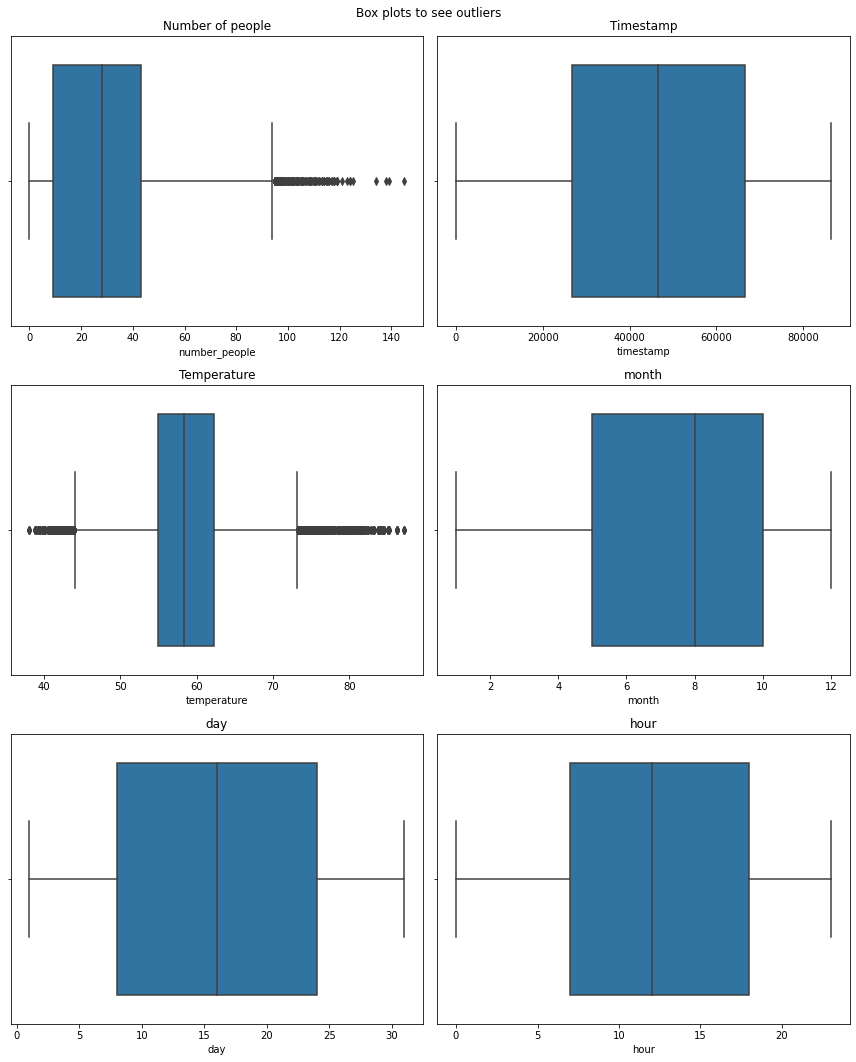

In [33]:
#Checking for outliers using boxplot
fig, ax = plt.subplots(3,2, figsize = (12, 15))
fig.suptitle('Box plots to see outliers')
ax[0][0].set_title('Number of people')
sns.boxplot(gym.number_people, ax = ax[0][0])
ax[0][1].set_title('Timestamp')
sns.boxplot(gym.timestamp, ax = ax[0][1])
ax[1][0].set_title('Temperature')
sns.boxplot(gym.temperature, ax = ax[1][0])
ax[1][1].set_title('month')
sns.boxplot(gym.month, ax = ax[1][1])
ax[2][0].set_title('day')
sns.boxplot(gym.day, ax = ax[2][0])
ax[2][1].set_title('hour')
sns.boxplot(gym.hour, ax = ax[2][1])
plt.tight_layout()

There are outliers in Timestamp and number of people but w wont drop them as huge part of data will be lost

Treating data to be modelled.

In [34]:
# splitting data and scaling data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(gym, train_size = 0.7, test_size = 0.3, random_state = 42)
dtrain = df_train.copy()
dtest = df_test.copy()
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
cols = list(dtrain.columns)
dtrain[cols] = scaler.fit_transform(dtrain[cols])
dtest[cols] = scaler.transform(dtest[cols])

In [35]:
dtest.shape , dtrain.shape


((18656, 12), (43528, 12))

In [36]:
xtrain = dtrain[[x for x in dtrain.columns if x not in ['number_people']]]
ytrain = dtrain['number_people']

xtest = dtest[[x for x in dtest.columns if x not in ['number_people']]]
ytest = dtest['number_people']

# creating model

In [37]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
xtrain = sm.add_constant(xtrain)
model = sm.OLS(ytrain, xtrain).fit()

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          number_people   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     4414.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:45:12   Log-Likelihood:                -27835.
No. Observations:               43528   AIC:                         5.569e+04
Df Residuals:                   43516   BIC:                         5.580e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -7.6957      0.188    -40.837      0.000      -8.065      -7.326
timestamp             -241.0199      5.783    -41.676      0.000    -252.355    -229.685
day_of_week             -0.1027      0.007    -14.154      0.000      -0.117      -0.088
is_weekend              -0.1643      0.008    -20.479      0.000      -0.180      -0.149
is_holiday              -0.4097      0.045     -9.166      0.000      -0.497      -0.322
temperature              0.1804      0.003     68.939      0.000       0.175       0.186
is_start_of_semester     0.2125      0.009     24.938      0.000       0.196       0.229
is_during_semester       0.3370      0.005     68.600      0.000       0.327       0.347
month                   -0.1007      0.003    -30.670      0.000      -0.107      -0.094
hour                   238.3507      5.706     41.770      0.000     227.166     249.535
minute                   9.3486      0.225     41.574      0.000       8.908       9.789
day                     -0.0465      0.004    -11.501      0.000      -0.054      -0.039
==============================================================================
Omnibus:                     1098.183   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2130.607
Skew:                           0.179   Prob(JB):                         0.00
Kurtosis:                       4.023   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
def analyse(model, x, y, label):
    y_pred = model.predict(x)
    residuals =  y_pred - y
    
    rmse = sqrt(mean_squared_error(y, y_pred))
    print('Model RMSE:',round(rmse, 4))

    r2=r2_score(y, y_pred)
    print('Model r2_score:',round(r2, 4))


    fig , ax = plt.subplots(1,3, figsize = (15,5))
    plt.suptitle(f'Model analysis for {label} data', fontsize=30)
    ax[0].set_title('Error Distribution')
    ax[0].set_xlabel('Error Values')
    p1 = sns.histplot(residuals, kde = True, bins = 50, ax = ax[0])
    
    ax[1].set_title('actual vs predictions')
    ax[1].set_ylabel('predictons')
    ax[1].set_xlabel('actual')
    p2 = sns.scatterplot(y, y_pred, ax = ax[1])
    ax[2].set_title('Residual plot')
    
    p3 = sns.residplot(y, residuals, lowess = True, ax = ax[2])
    ax[2].set_ylabel('residuals')
    ax[2].set_xlabel('number of people')
    plt.tight_layout()

Model RMSE: 0.4586
Model r2_score: 0.5273


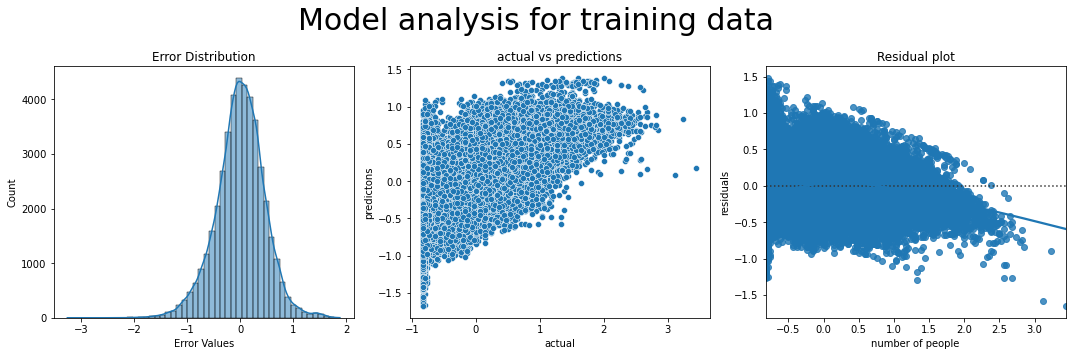

In [40]:
analyse(model, xtrain, ytrain, 'training')

In [41]:
# VIF analysis
from statsmodels.stats.outliers_influence  import  variance_inflation_factor 
def get_VIF(X_train):
 # A dataframe that will contain the names of all the feature variables and their respective VIFs 
    vif = pd.DataFrame() 
    vif['Features'] = X_train.columns 
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])] 
    #vif['VIF'] = (vif['VIF'], 2) 
    vif = vif.sort_values(by = "VIF", ascending = False) 
    return (vif)

In [42]:
vif_ = pd.DataFrame(get_VIF(xtrain))
vif_

Features           VIF
1              timestamp  2.517164e+06
9                   hour  2.510831e+06
0                  const  7.346444e+03
10                minute  4.646235e+03
2            day_of_week  2.704697e+00
3             is_weekend  2.698555e+00
7     is_during_semester  1.117511e+00
6   is_start_of_semester  1.091965e+00
5            temperature  1.075834e+00
8                  month  1.058845e+00
4             is_holiday  1.032309e+00
11                   day  1.024287e+00

In [43]:
#Extreme vif is present in timestamp so we will drop it
xtrain.drop('timestamp', axis = 1, inplace = True)
xtest.drop('timestamp', axis = 1, inplace = True)

In [44]:
xtrain = sm.add_constant(xtrain)
xtest = sm.add_constant(xtest)
model = sm.OLS(ytrain, xtrain).fit()

In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          number_people   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     4502.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                -28687.
No. Observations:               43528   AIC:                         5.740e+04
Df Residuals:                   43517   BIC:                         5.749e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1565      0.004     42.077      0.000       0.149       0.164
day_of_week             -0.1028      0.007    -13.905      0.000      -0.117      -0.088
is_weekend              -0.1588      0.008    -19.416      0.000      -0.175      -0.143
is_holiday              -0.4433      0.046     -9.728      0.000      -0.533      -0.354
temperature              0.1805      0.003     67.624      0.000       0.175       0.186
is_start_of_semester     0.2067      0.009     23.784      0.000       0.190       0.224
is_during_semester       0.3646      0.005     73.459      0.000       0.355       0.374
month                   -0.1120      0.003    -33.572      0.000      -0.119      -0.105
hour                     0.5411      0.004    144.627      0.000       0.534       0.548
minute                  -0.0218      0.003     -6.466      0.000      -0.028      -0.015
day                     -0.0426      0.004    -10.346      0.000      -0.051      -0.035
==============================================================================
Omnibus:                     1366.981   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2371.095
Skew:                           0.272   Prob(JB):                         0.00
Kurtosis:                       4.006   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
vif_ = pd.DataFrame(get_VIF(xtrain))
vif_

Features       VIF
0                  const  2.752730
1            day_of_week  2.704696
2             is_weekend  2.697831
6     is_during_semester  1.097159
5   is_start_of_semester  1.091667
4            temperature  1.075834
7                  month  1.051599
8                   hour  1.037968
3             is_holiday  1.031972
10                   day  1.023751
9                 minute  1.000377

VIF values are under control but there is no improvement in model

Model RMSE: 0.4649
Model r2_score: 0.5153


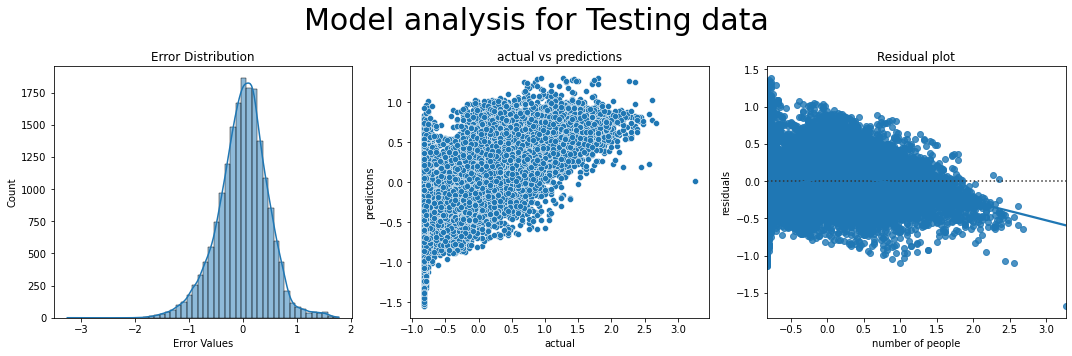

In [47]:
# running on testing data
analyse(model, xtest, ytest, 'Testing')

Linear regression is not suitable for the data the errors have normal distribution but prediction errors are very high and homoscadasticity is very low.

Using decision tree regressor 

In [48]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(max_depth = 5)
dtree.fit(xtrain, ytrain)

DecisionTreeRegressor(max_depth=5)

Model RMSE: 0.404
Model r2_score: 0.6333


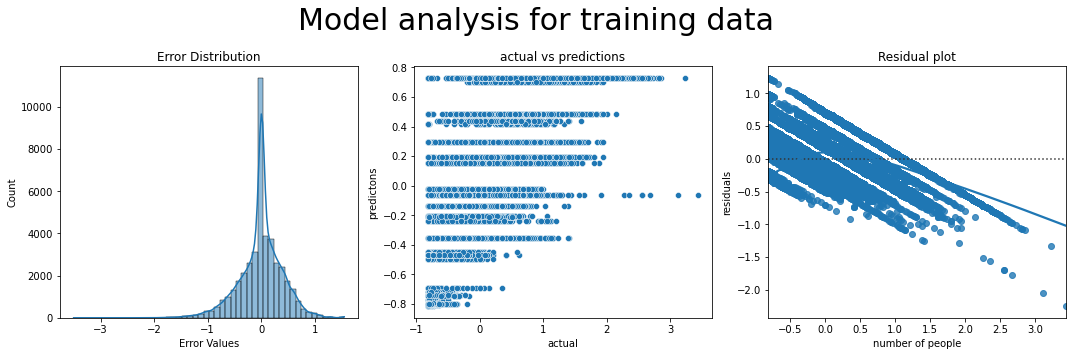

In [49]:
analyse(dtree, xtrain, ytrain, 'training')

Model RMSE: 0.4049
Model r2_score: 0.6324


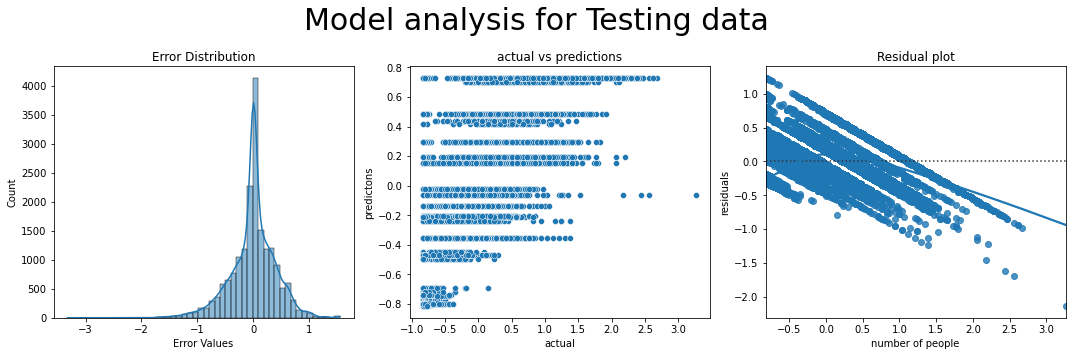

In [50]:
analyse(dtree, xtest, ytest, 'Testing')

Model RMSE: 0.2432
Model r2_score: 0.8671


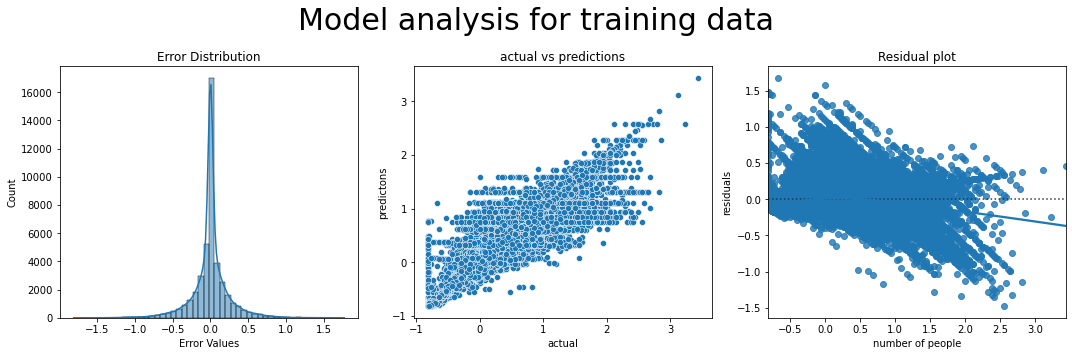

In [51]:
dtree = DecisionTreeRegressor(max_depth = 14)
dtree.fit(xtrain, ytrain)
analyse(dtree, xtrain, ytrain, 'training')


Model RMSE: 0.2803
Model r2_score: 0.8238


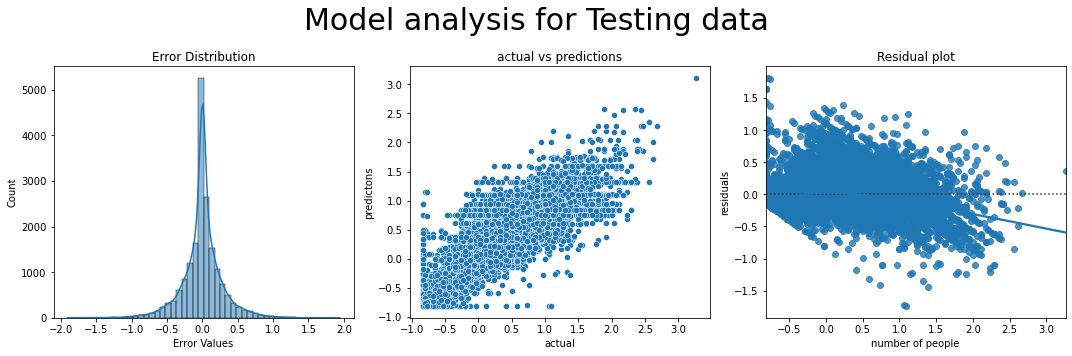

In [52]:
analyse(dtree, xtest, ytest, 'Testing')

decision tree regressor is quite efficient for higher vale of depths, the predictions and actual values are much closer as compared to linear regression. homoscadasticity is still low for this regressor.

Model RMSE: 0.3996
Model r2_score: 0.6413


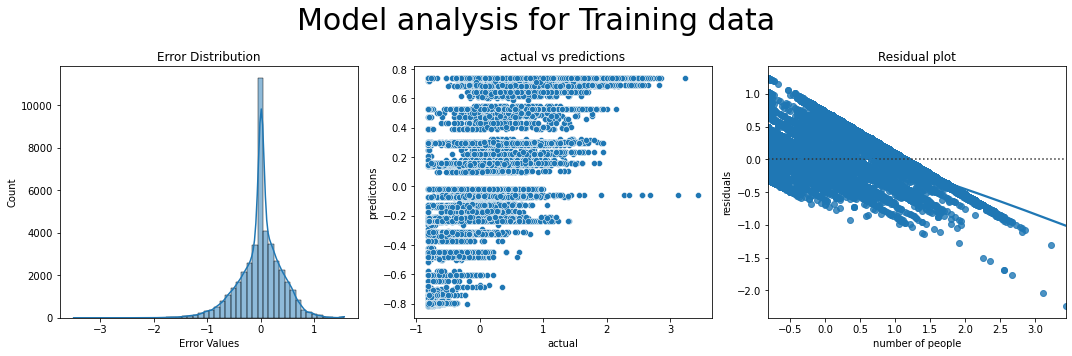

In [53]:
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(max_depth = 5)
rforest.fit(xtrain, ytrain)
analyse(rforest, xtrain, ytrain, 'Training')

Model RMSE: 0.4004
Model r2_score: 0.6404


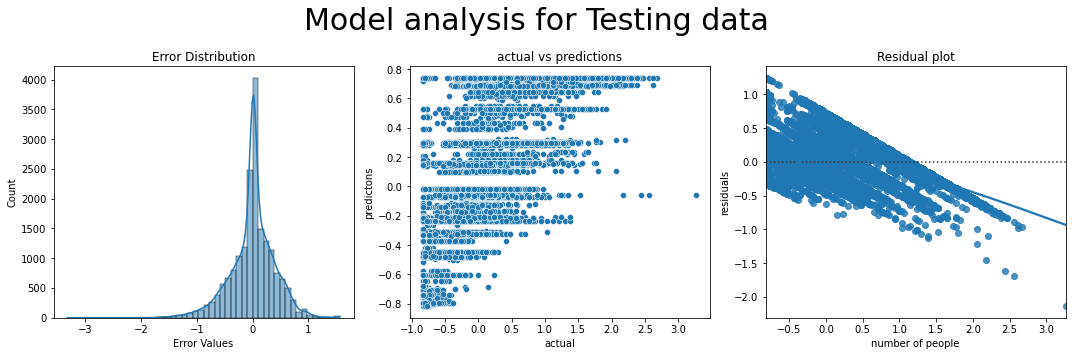

In [54]:
analyse(rforest, xtest, ytest, 'Testing')

Model RMSE: 0.1961
Model r2_score: 0.9136


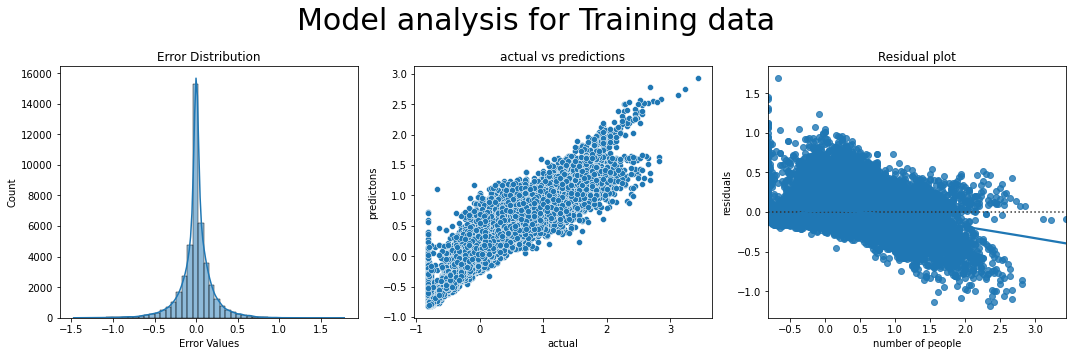

In [55]:
rforest = RandomForestRegressor( max_depth = 15)
rforest.fit(xtrain, ytrain)
analyse(rforest, xtrain, ytrain, 'Training')

Model RMSE: 0.2328
Model r2_score: 0.8784


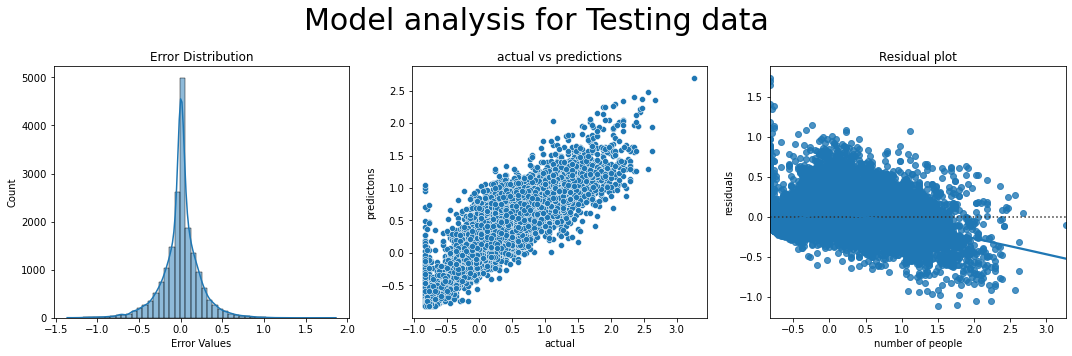

In [56]:
analyse(rforest, xtest, ytest, 'Testing')

random forest regressor is quite efficient for higher vale of depths, the predictions and actual values are much closer as compared to linear regression. homoscadasticity is still low for this regressor.

In [57]:
import xgboost
from xgboost import XGBRegressor
params = {
    'objective' :'reg:squarederror',
    'n_estimators': 1000,
    
    'alpha': 10,
    
    
        } 


Model RMSE: 0.2011
Model r2_score: 0.9092


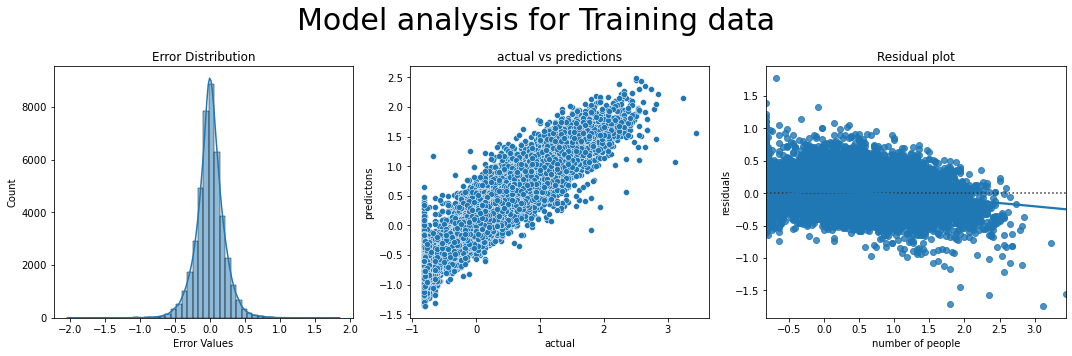

In [58]:
xgb = XGBRegressor(**params, learning_rate = 1.0, max_depth = 5,)
xgb.fit(xtrain, ytrain)
analyse(xgb, xtrain, ytrain, 'Training')

Model RMSE: 0.2208
Model r2_score: 0.8907


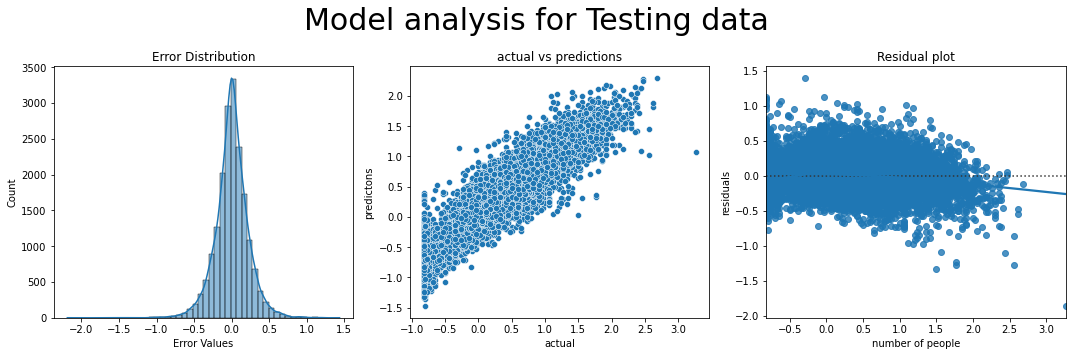

In [59]:
analyse(xgb, xtest, ytest, 'Testing')

Model RMSE: 0.1909
Model r2_score: 0.9182


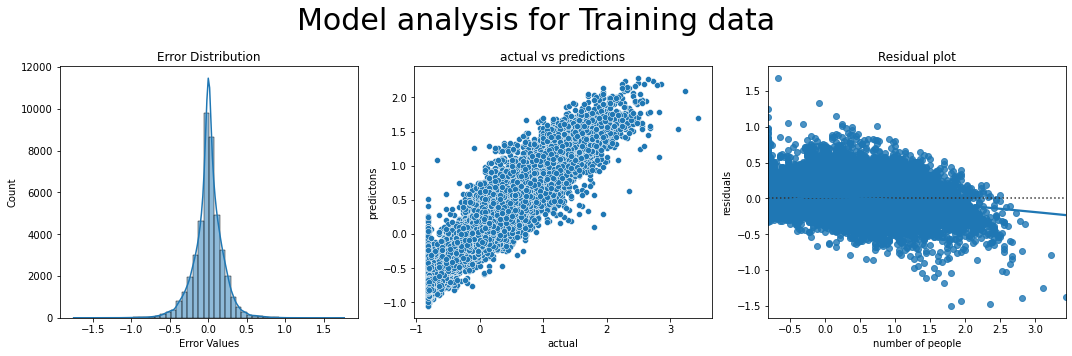

In [60]:
xgb = XGBRegressor(**params, learning_rate = 0.01, max_depth = 15,)
xgb.fit(xtrain, ytrain)
analyse(xgb, xtrain, ytrain, 'Training')

Model RMSE: 0.2076
Model r2_score: 0.9033


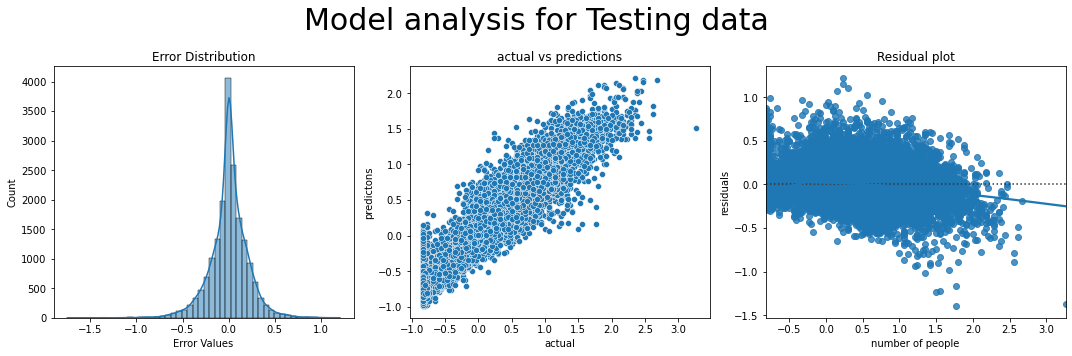

In [61]:
analyse(xgb, xtest, ytest, 'Testing')

So far XGBregressor has been the best model. Fitting for test and train data is well within bounds. Residuals are higher than Decision Tree but higher r2 score is obtained. Homoscadasticity is still not achieved.

# Using Box cox transform to normalize the data

In [62]:
from scipy import stats

In [63]:
df_train.drop('timestamp', axis = 1, inplace = True)
df_test.drop('timestamp', axis = 1, inplace = True)


In [64]:
# columns to be normalized
cols = ['number_people','hour','minute','day_of_week','day','month','temperature']
for i in cols:
    df_train[i] = df_train[i].apply(lambda x: x + 1)
    df_test[i] = df_test[i].apply(lambda x: x + 1)
    df_train[i], fit_lambda = stats.boxcox(df_train[i])
    df_test[i] = stats.boxcox(df_test[i], fit_lambda)

<AxesSubplot:xlabel='number_people', ylabel='Count'>

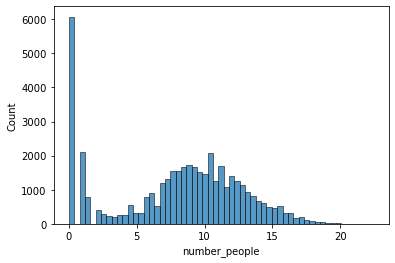

In [65]:
sns.histplot(df_train.number_people)

<AxesSubplot:xlabel='temperature', ylabel='Count'>

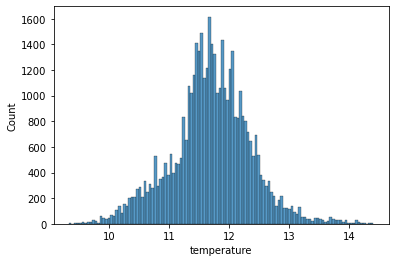

In [66]:
sns.histplot(df_train.temperature)

<AxesSubplot:xlabel='hour', ylabel='Count'>

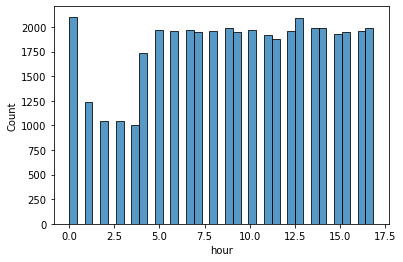

In [67]:
sns.histplot(df_train.hour)

<AxesSubplot:>

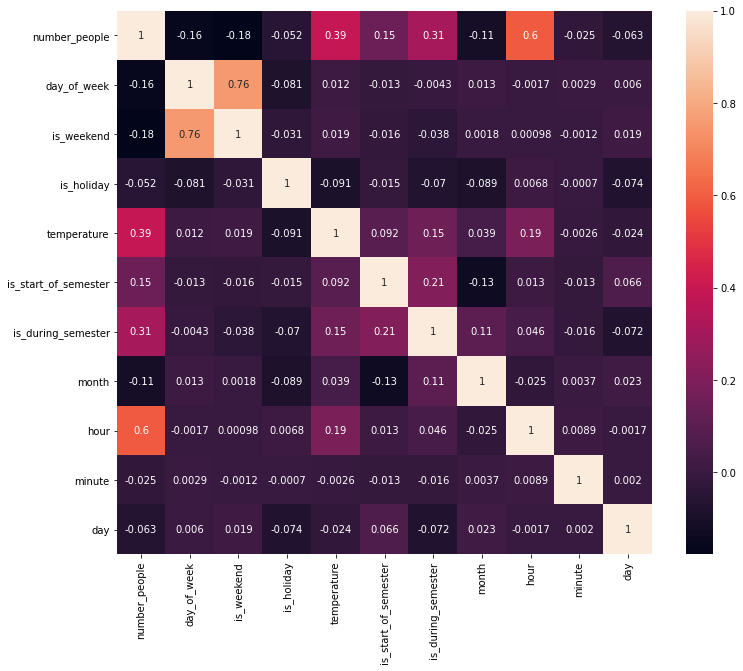

In [68]:
fig = plt.figure(figsize = (12,10) )
sns.heatmap(df_train.corr(), annot = True)

In [69]:
scaler = RobustScaler()
cols = list(df_train.columns)
df_train[cols] = scaler.fit_transform(df_train[cols])
df_test[cols] = scaler.transform(df_test[cols])
xtrain = df_train[[x for x in df_train.columns if x not in ['number_people']]]
ytrain = df_train['number_people']

xtest = df_test[[x for x in df_test.columns if x not in ['number_people']]]
ytest = df_test['number_people']

In [70]:
xtrain = sm.add_constant(xtrain)
xtest = sm.add_constant(xtest)
model = sm.OLS(ytrain, xtrain).fit()

Model RMSE: 0.4653
Model r2_score: 0.5474


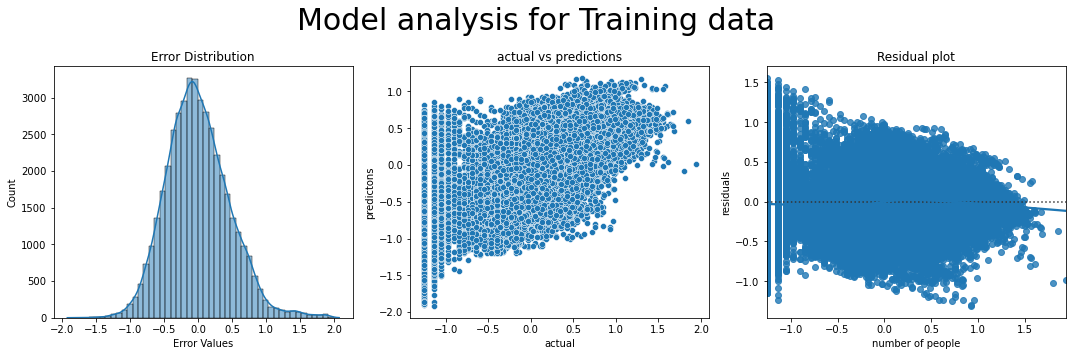

In [71]:
analyse(model, xtrain, ytrain, 'Training')

Model RMSE: 0.4653
Model r2_score: 0.5529


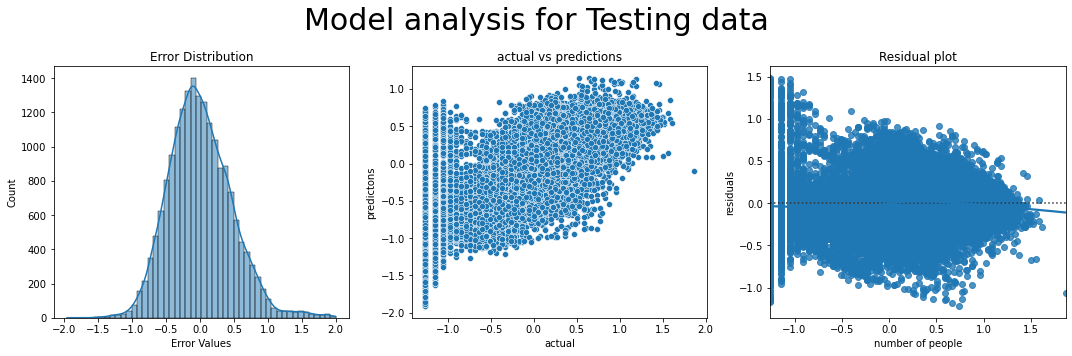

In [72]:
analyse(model, xtest, ytest, 'Testing')

Using Box Cox Transformation we have gained 2 percent increase in training r2 score and 4 percent increase in testing r2 score for Ordinary least square linear regressor

Model RMSE: 0.1941
Model r2_score: 0.9213


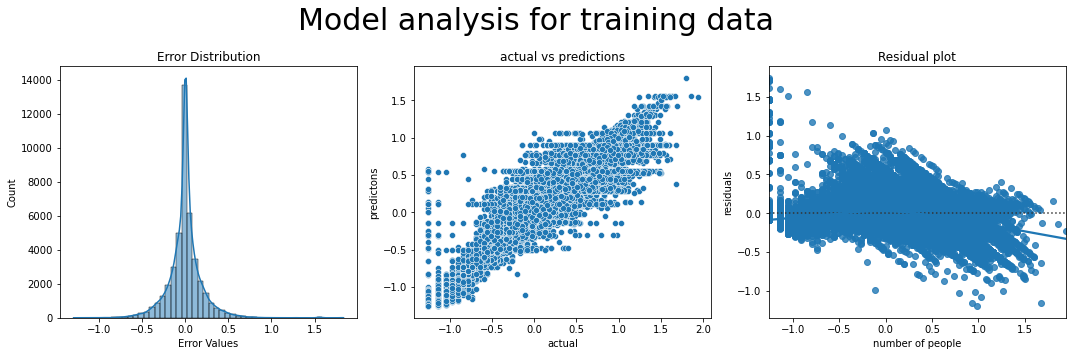

In [73]:
# checking for decision tree regressor
dtree = DecisionTreeRegressor(max_depth = 14)
dtree.fit(xtrain, ytrain)
analyse(dtree, xtrain, ytrain, 'training')

Model RMSE: 0.2355
Model r2_score: 0.8855


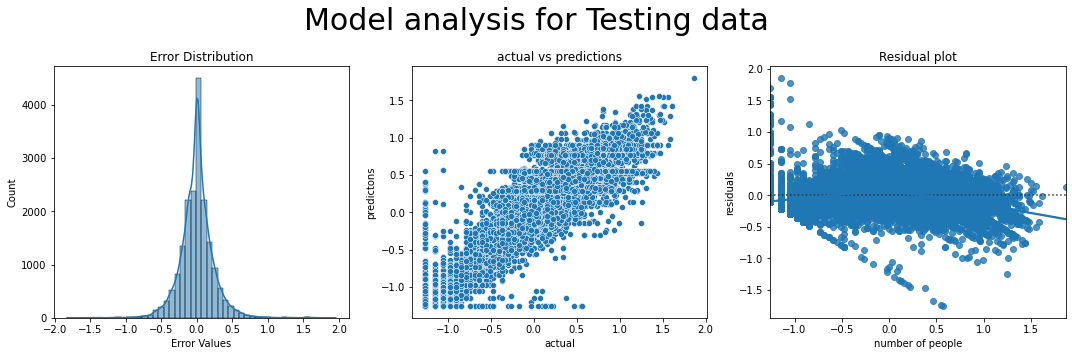

In [74]:
analyse(dtree, xtest, ytest, 'Testing')

Using Box cox transformation we have gained 6 percent r2 in training data and 6 percent r2 in testing data. However Homoscadasticity is still less

Model RMSE: 0.1546
Model r2_score: 0.95


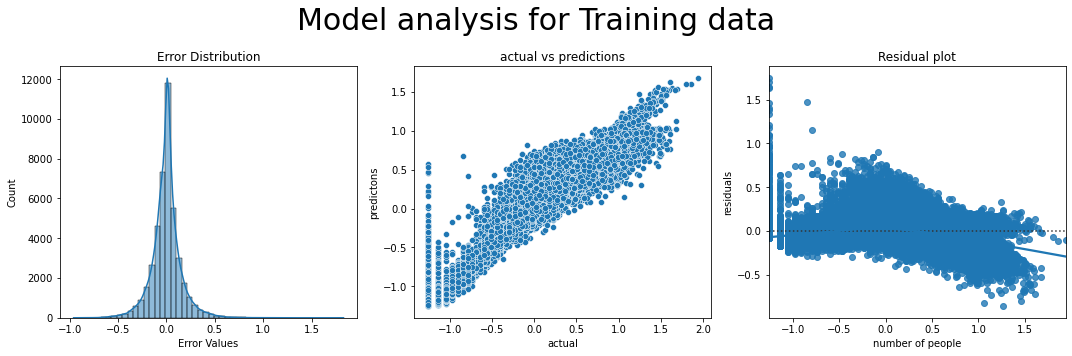

In [75]:
rforest = RandomForestRegressor( max_depth = 15)
rforest.fit(xtrain, ytrain)
analyse(rforest, xtrain, ytrain, 'Training')

Model RMSE: 0.1914
Model r2_score: 0.9244


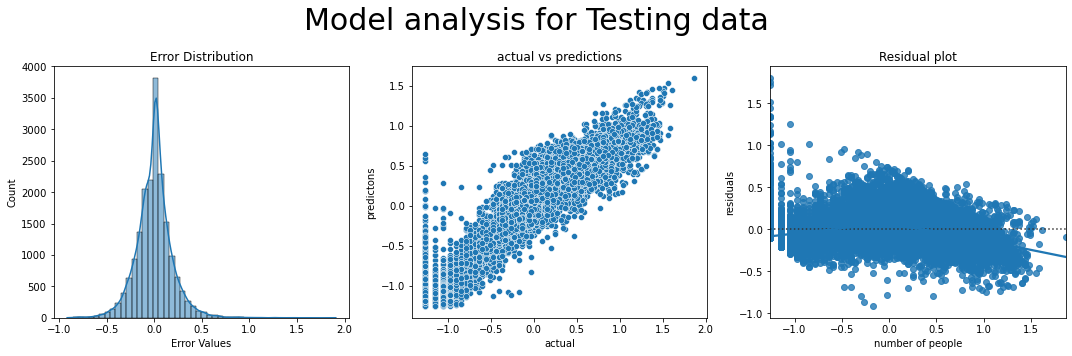

In [76]:
analyse(rforest, xtest, ytest, 'Testing')

Using Box cox transformation we have gained 3 percent r2 in training data and 5 percent r2 in testing data. However Homoscadasticity is still less

Model RMSE: 0.1662
Model r2_score: 0.9422


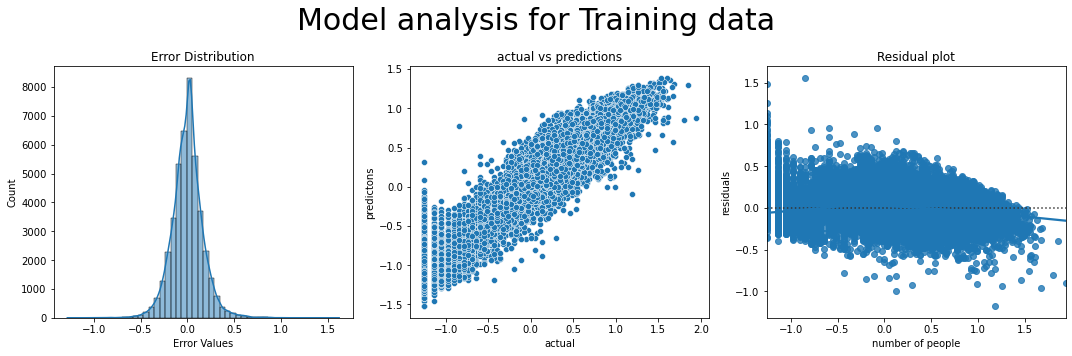

In [77]:
xgb = XGBRegressor(**params, learning_rate = 0.01, max_depth = 15,)
xgb.fit(xtrain, ytrain)
analyse(xgb, xtrain, ytrain, 'Training')

Model RMSE: 0.1787
Model r2_score: 0.9341


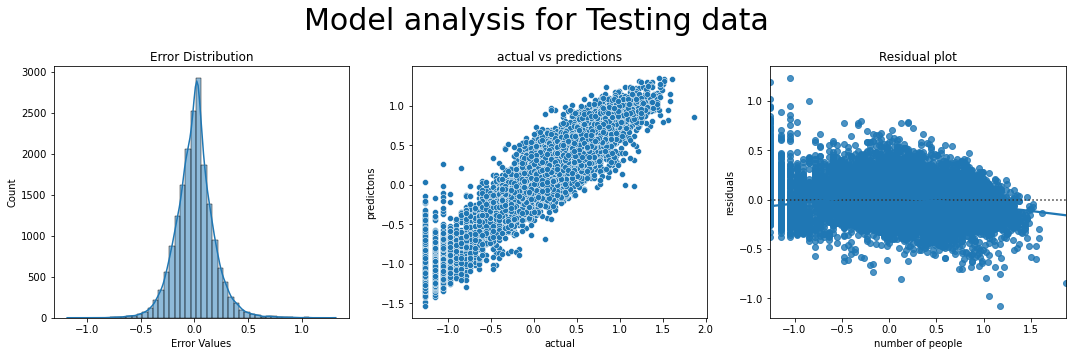

In [78]:
analyse(xgb, xtest, ytest, 'Testing')

Using Box cox transformation we have gained 3 percent r2 in training data and 3 percent r2 in testing data. However Homoscadasticity is still less but improved to some extent.

# Principle Component Analysis


In [80]:
xtrain.drop('const', axis = 1, inplace = True)
xtest.drop('const', axis = 1, inplace = True)

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)  # consider enough components to explain 90% of the variance
pca.fit(xtrain)
pca_train = pd.DataFrame(pca.transform(xtrain))
pca_train.columns = ['PC'+str(i+1) for i in range(len(pca_train.columns))]
loadings_train = pd.DataFrame(pca.components_, columns=xtrain.columns)
loadings_train.index = ['PC'+str(i+1) for i in range(len(pca_train.columns))]
pca_test = pd.DataFrame(pca.transform(xtest))
pca_test.columns = ['PC'+str(i+1) for i in range(len(pca_test.columns))]
loadings_test = pd.DataFrame(pca.components_, columns=xtest.columns)
loadings_test.index = ['PC'+str(i+1) for i in range(len(pca_test.columns))]

In [95]:
pca_train.shape, pca_test.shape

((43528, 7), (18656, 7))

In [97]:
loadings_train.shape, loadings_test.shape

((7, 10), (7, 10))

In [98]:
pca_train.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -0.568687  0.745040 -0.084598  0.929599 -0.938004 -0.160579  0.568720
1  1.087818 -0.127720 -0.152804 -0.373918  0.601199 -0.413756 -0.226113
2  0.762856 -0.231732  0.369230 -0.797332  0.239651  0.090111  0.801128
3 -1.194979 -1.026209 -0.917442  0.827565  0.035100 -0.426293 -0.501566
4 -0.729295  0.874709 -0.817287 -0.187354  0.088608 -0.006077 -0.315032

In [99]:
pca_test.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -0.031433  0.075355 -0.457987 -0.549178 -0.804738 -0.325830 -0.295395
1  0.748673 -1.139214 -0.647609  0.889014  0.342794  0.765986 -0.118484
2  0.041427  0.040813  0.255101  1.054880  0.920838 -0.479745  0.529984
3  2.114833 -0.479392  0.025460 -0.655978  0.386189  0.409900 -0.162539
4  0.016890  1.051998 -0.980408  0.833432 -0.771820 -0.174144 -0.266479

In [102]:
xtrain = sm.add_constant(pca_train)
xtest = sm.add_constant(pca_test)
from sklearn.linear_model import LinearRegression
lenreg = LinearRegression()
lenreg.fit(pca_train, ytrain)

LinearRegression()

Model RMSE: 0.4667
Model r2_score: 0.5446


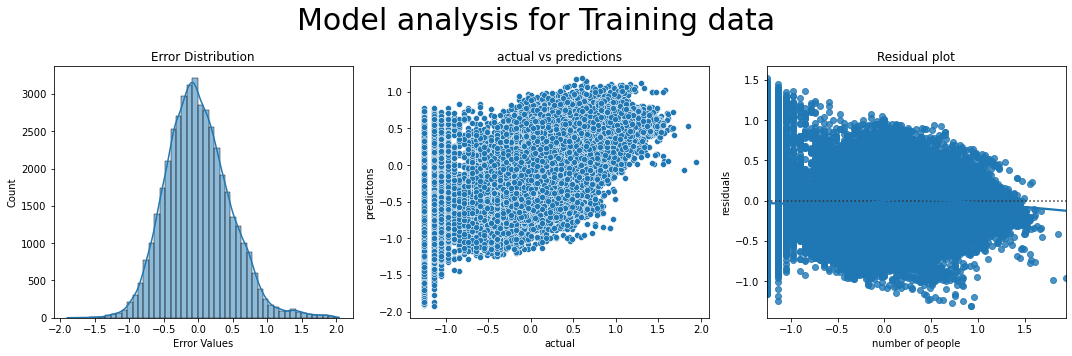

In [103]:
analyse(lenreg, pca_train, ytrain, 'Training')

Model RMSE: 0.4664
Model r2_score: 0.5509


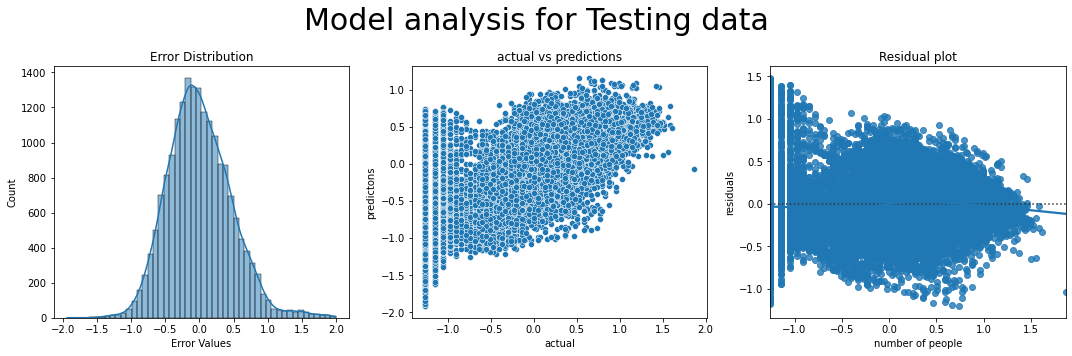

In [104]:
analyse(lenreg, pca_test, ytest, 'Testing')

Model RMSE: 0.1913
Model r2_score: 0.9235


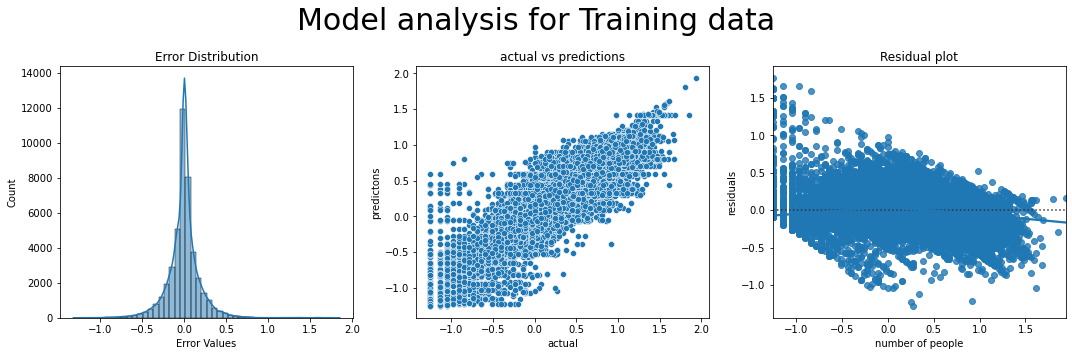

In [106]:
dtree.fit(pca_train, ytrain)
analyse(dtree, pca_train, ytrain, 'Training')

Model RMSE: 0.2785
Model r2_score: 0.8398


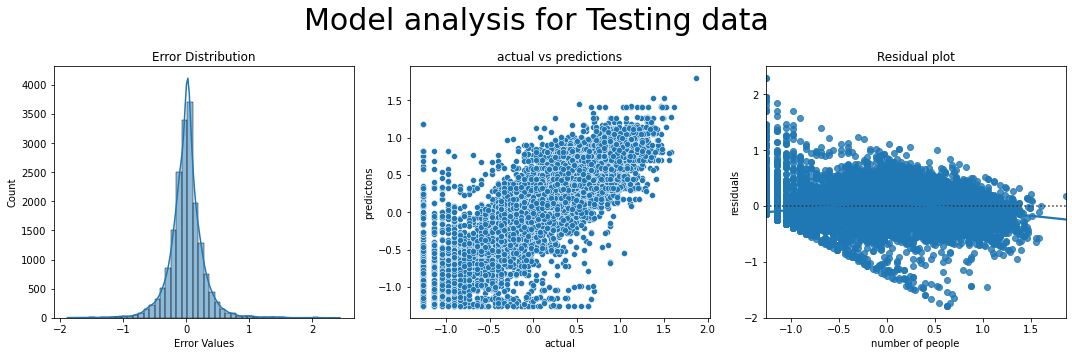

In [107]:
analyse(dtree, pca_test, ytest, 'Testing')

Model RMSE: 0.1488
Model r2_score: 0.9537


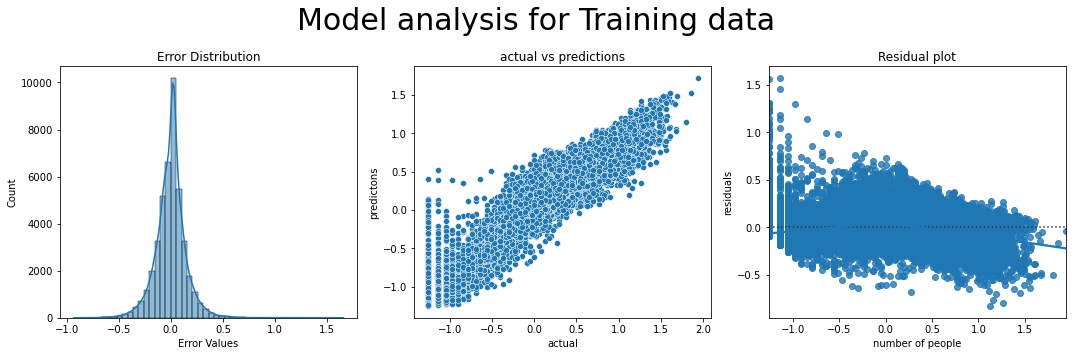

In [109]:
rforest.fit(pca_train, ytrain)
analyse(rforest, pca_train, ytrain, 'Training')

Model RMSE: 0.209
Model r2_score: 0.9099


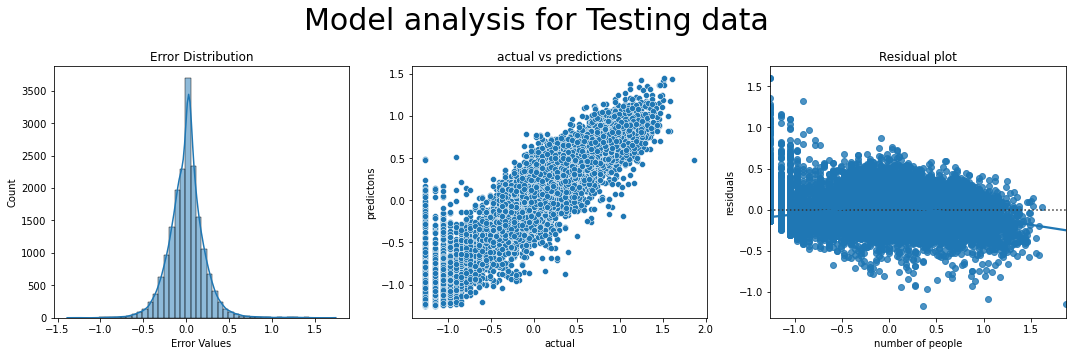

In [110]:
analyse(rforest, pca_test, ytest, 'Testing')

Model RMSE: 0.1686
Model r2_score: 0.9406


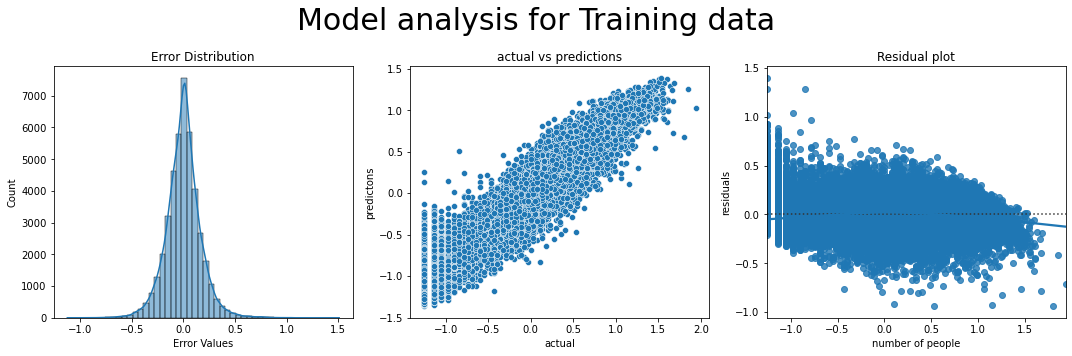

In [113]:
xgb.fit(pca_train, ytrain)
analyse(xgb, pca_train, ytrain, 'Training')

Model RMSE: 0.2136
Model r2_score: 0.9058


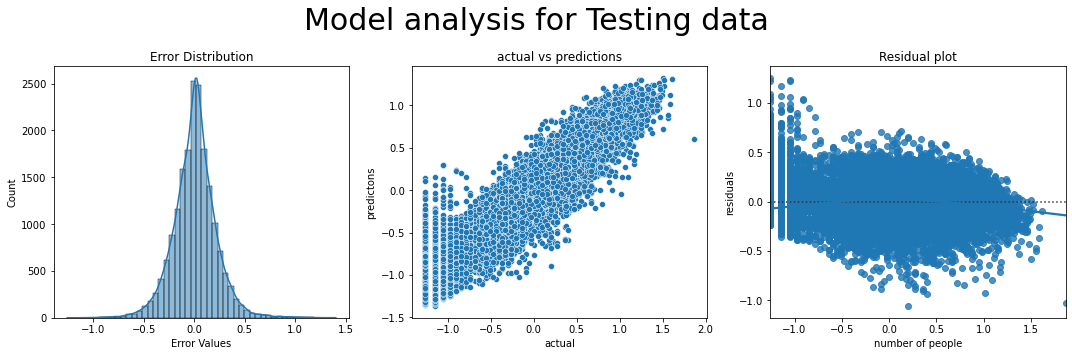

In [114]:
analyse(xgb, pca_test, ytest, 'Testing')